In [1]:
cd /home

/home


# Astromer I vs Astromer II

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import os

from sklearn.metrics import r2_score, mean_squared_error
from presentation.experiments.utils import get_clf_summary
from src.utils import get_metrics

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

2023-09-25 15:42:10.636854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


**WARNING**: This notebook was made to visualize classification results only. 

All the following blocks assume you already ran the script `./presentation/experiments/astromer_{1/2}/script.py`.

The directory looks like: 
- `presentation`
    - `astromer_1/results/<experiment_folder>`
        - `finetuning`
        - `classification`
        - `pretraining`
    - `astromer_2/results/<experiment_folder>`
        - `finetuning`
        - `classification`
        - `pretraining`

In [15]:
folders = [
    './presentation/experiments/astromer_1/results/paper/2023-09-21_20-16-21/',
     './presentation/experiments/astromer_1/results/paper/2023-09-21_20-24-32/',
]
tags = ['50\% Probed', '20\% Probed']

In [16]:
summary = []
for folder, tag in zip(folders, tags):
    partial = get_clf_summary(folder, tag)
    summary.append(partial)
    
summary = pd.concat(summary, axis=0)

In [17]:
summary.shape

(24, 33)

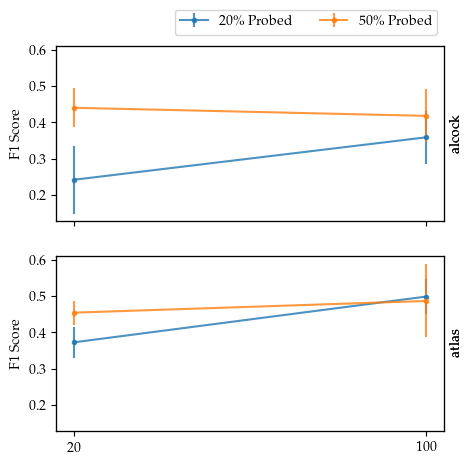

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(5,5), sharex=True, sharey=True)
count = 0
delta = 0.2
for downstream_data, frame_0 in summary.groupby('downstream_data'):
    shift = 0
    for tag, frame_1 in frame_0.groupby('tag'):
        x_tickslab, mean_values, std_values = [], [], []
        for (spc, clfname), frame_2 in frame_1.groupby(['samples_per_class', 'clf_name']):
            f1_values = frame_2['clf_val_acc'].astype(float)
            x_tickslab.append(int(spc))
            mean_values.append(f1_values.mean())
            std_values.append(f1_values.std())
        
        indices = np.argsort(x_tickslab)
        
        mean_values = np.array(mean_values)[indices]
        std_values  = np.array(std_values)[indices]
        
        
        axes[count].errorbar(x_tickslab, mean_values,yerr=std_values, marker='.', label=tag, alpha=0.8)
        axes[count].set_xticks(x_tickslab)
        axes[count].set_xticklabels(x_tickslab, rotation=0)
        axes[count].set_ylabel('F1 Score')
        
        axes[count].yaxis.tick_right()
        ax2 = axes[count].twinx()
        ax2.set_ylabel(downstream_data)
        ax2.set_yticks([])
    
    count+=1
axes[0].legend(bbox_to_anchor=(1., 1.25), ncol=2)